<a href="https://colab.research.google.com/github/skugele/polyomino-imagery-env/blob/environment-additions/bvae_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
# PARAMETERS
INPUT_HEIGHT = 128
INPUT_WIDTH = 128



In [3]:
class Preprocessor(tf.keras.Model):
  def __init__(self):
    super().__init__(name="preprocessor")
    self.resizer = tf.keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH, name=f"{self.name}_resizer")
    self.rescaler = tf.keras.layers.Rescaling(scale=1./255, name=f"{self.name}_rescaler")

  def call(self, inputs):
    return self.rescaler(
        self.resizer(inputs)
    )

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose

In [5]:


class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dims):
    super().__init__(name="encoder")

    self.latent_dims = latent_dims

    # layers
    self.preprocess = Preprocessor()

    self.conv1 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv1')
    self.mpool1 = MaxPool2D(name='encoder_mpool1')

    self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv2')
    self.mpool2 = MaxPool2D(name='encoder_mpool2')

    self.conv3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv3')
    self.mpool3 = MaxPool2D(name='encoder_mpool3')

    self.conv4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv4')
    self.mpool4 = MaxPool2D(name='encoder_mpool4')

    self.flatten = Flatten(name='encoder_flatten')

    self.logvar = Dense(self.latent_dims, name='encoder_logvar')
    self.mu = Dense(self.latent_dims, name='encoder_mu')
    self.sigma = Lambda(lambda x: tf.exp(0.5*x), name='encoder_sigma')

  def encode(self, inputs, preprocess=True):
    # print the shape of the input
    # print(f"Shape of input to encoder: {inputs.shape}")
    p = self.preprocess(inputs) if preprocess else inputs
    x=self.conv1(p); x=self.mpool1(x)
    x=self.conv2(x); x=self.mpool2(x)
    x=self.conv3(x); x=self.mpool3(x)
    x=self.conv4(x); x=self.mpool4(x)
    x=self.flatten(x)
    # print(f"Shape of output from encoder: {x.shape}")

    return self.mu(x), self.logvar(x), self.sigma(self.logvar(x)), p


  def call(self, inputs):
    return self.encode(inputs)

  def summary(self, input_shape):
    x = tf.keras.layers.Input(shape=input_shape)
    model = tf.keras.Model(inputs=[x], outputs=self.call(x))
    return model.summary()


In [6]:
class Decoder(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__(name="decoder")

    self.latent_dims = latent_dims

    # layers
    self.dense1 = Dense(256 * 8 * 8, activation="relu", name='decoder_dense1')
    self.reshape1 = Reshape((8, 8, 256), name='decoder_reshape1')

    self.conv1 = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_conv1')
    self.conv2 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_conv2')
    self.conv3 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_conv3')
    self.conv4 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_conv4')
    self.conv5 = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='decoder_conv5')

  def decode(self, inputs):
    # print the shape of the input
    # print(f"Shape of input to decoder: {inputs.shape}")
    x = self.dense1(inputs)
    x = self.reshape1(x)

    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    # print(f"Shape of output from decoder: {x.shape}")

    return x

  def call(self, inputs):
    return self.decode(inputs)

  # def summary(self, input_shape):
  #   x = tf.keras.layers.Input(shape=input_shape)
  #   model = tf.keras.Model(inputs=[x], outputs=self.call(x))
  #   return model.summary()

In [7]:
class ReconstructionLoss(tf.keras.layers.Layer):
  def __init__(self):
    super(ReconstructionLoss, self).__init__(name="reconstruction_loss")

  def call(self, inputs):
    x = inputs[0]
    recon_x = inputs[1]

    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x), axis=[1,2])
    recon_loss = tf.reduce_mean(recon_loss)

    self.add_loss(recon_loss)

    return recon_loss

In [8]:
class KLLoss(tf.keras.layers.Layer):
  def __init__(self):
    super(KLLoss, self).__init__()

    self.beta = tf.Variable(1.0, name="beta")

  def call(self, inputs):
    mu = inputs[0]
    logvar = inputs[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    kl_loss = kl_loss * self.beta

    self.add_loss(kl_loss)
    return kl_loss

In [9]:
# Sampler

class Sampler(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="sampler")

  def call(self, inputs):
    mu = inputs[0]
    sigma = inputs[1]

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))

    # reparameterize
    output =  mu + tf.multiply(sigma, epsilon)

    # print(f"Shape of output from sampler: {output.shape}")
    return output



In [10]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__(name="bvae")

    self.latent_dims = latent_dims

    # layers
    self.encoder = Encoder(self.latent_dims)
    self.decoder = Decoder(self.latent_dims)

    self.sampler = Sampler()

    self.reconstruction_loss = ReconstructionLoss()
    self.kl_loss = KLLoss()

    # trackers
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

  def call(self, inputs):
    mu, logvar, sigma, x = self.encoder(inputs)
    z = self.sampler([mu, sigma])
    # print(f"Shape of z: {z.shape}")
    recon_x = self.decoder(z)

    kl_loss = self.kl_loss([mu, logvar])
    reconstruction_loss = self.reconstruction_loss([x, recon_x])

    return recon_x, kl_loss, reconstruction_loss

  @property
  def metrics(self):
      return [
          self.loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
    # print(f"Shape of input data in train_step: {data.shape}")

    with tf.GradientTape() as tape:
      recon_x, kl_loss, reconstruction_loss = self(data)
      total_loss = reconstruction_loss + kl_loss

      # update the trackers
      self.loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      # gradients
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        m.name: m.result() for m in self.metrics
    }

  def test_step(self, data):
    recon_x, kl_loss, reconstruction_loss = self(data)
    total_loss = reconstruction_loss + kl_loss
    self.loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        m.name: m.result() for m in self.metrics
    }

  def encode(self, inputs, preprocess=True):
    return self.encoder.encode(inputs, preprocess=preprocess)

  def decode(self, inputs):
    return self.decoder.decode(inputs)

  def sample(self, mu, sigma):
    return self.sampler([mu, sigma])

  def calculate_reconstruction_loss(self, inputs):
    return self.reconstruction_loss(inputs)

  def calculate_kl_loss(self, inputs):
    return self.kl_loss(inputs)






In [11]:
class BetaVaeParameterUpdater(tf.keras.callbacks.Callback):
  def __init__(self, delta, limit):
    super().__init__()
    self.delta = delta
    self.limit = limit

  @tf.function
  def update_beta(self):
    beta = self.model.kl_loss.beta
    beta.assign(tf.math.maximum(beta - self.delta, self.limit))

  def on_epoch_end(self, epoch, logs=None):
    self.update_beta()

In [12]:
file_path = "./images_flat.zip"
# unzip
!unzip -q {file_path}

In [13]:
images_path = "./images/"


In [14]:
model = BVAE(latent_dims=8)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [126]:
# view model summary
model.encoder.summary((None, None, 1)) # Provide a valid input shape for the summary
model.decoder.summary((None, None, 1)) # Provide a valid input shape for the summary


Shape of input to encoder: (None, None, None, 1)
Shape of output from encoder: (None, 16384)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessor        │ (None, 128, 128,  │          0 │ input_layer_16[0… │
│ (Preprocessor)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv1       │ (None, 128, 128,  │        320 │ preprocessor[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mpool1      │ (None, 64, 64,    │          0 │ encoder_conv1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv2       │ (None, 64, 64,    │     18,496 │ encoder_mpool1[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mpool2      │ (None, 32, 32,    │          0 │ encoder_conv2[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv3       │ (None, 32, 32,    │     73,856 │ encoder_mpool2[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mpool3      │ (None, 16, 16,    │          0 │ encoder_conv3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv4       │ (None, 16, 16,    │    295,168 │ encoder_mpool3[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mpool4      │ (None, 8, 8, 256) │          0 │ encoder_conv4[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_flatten     │ (None, 16384)     │          0 │ encoder_mpool4[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_logvar      │ (None, 8)         │    131,080 │ encoder_flatten[… │
│ (Dense)             │                   │            │ encoder_flatten[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mu (Dense)  │ (None, 8)         │    131,080 │ encoder_flatten[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_sigma       │ (None, 8)         │          0 │ encoder_logvar[1… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 650,000 (2.48 MB)

 Trainable params: 650,000 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Shape of input to decoder: (None, None, None, 1)
Shape of output from decoder: (None, 128, 128, 1)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense1 (Dense)          │ (None, None, None,     │        32,768 │
│                                 │ 16384)                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_reshape1 (Reshape)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv1 (Conv2DTranspose) │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv2 (Conv2DTranspose) │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv3 (Conv2DTranspose) │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv4 (Conv2DTranspose) │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv5 (Conv2DTranspose) │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,433 (3.85 MB)

 Trainable params: 1,010,433 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
images = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels=None,
    color_mode='grayscale',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True, # Ensure shuffling for random split
    seed=42 # Optional: Set seed for reproducible split
)

# Calculate the size of the dataset
dataset_size = tf.data.experimental.cardinality(images).numpy()

train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset using take and skip
train_ds = images.take(train_size)
test_ds = images.skip(train_size)

Found 1899 files.


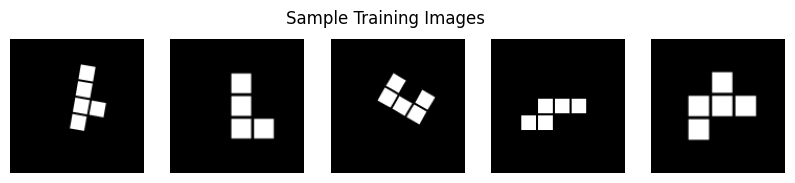

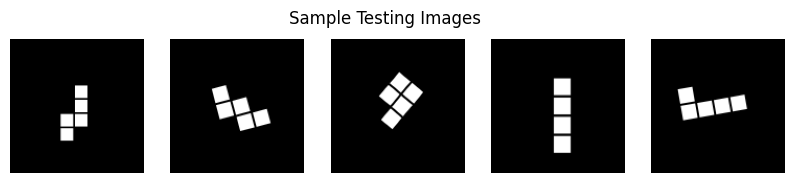

In [16]:
# prompt: plot part of the dataset

import matplotlib.pyplot as plt

# Take the first batch from the training dataset
for batch in train_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
num_images_to_plot = 5
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.show()

# Take the first batch from the testing dataset
for batch in test_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Testing Images')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

beta_updater_callback = BetaVaeParameterUpdater(delta=0.01, limit=0.0) # Example values
history = model.fit(
    train_ds,
    epochs=1000, # Adjust the number of epochs as needed
    validation_data=test_ds,
    callbacks=[beta_updater_callback] # Add the callback
)

# Plot training history (optional)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - kl_loss: 14.2812 - loss: 3187.3901 - reconstruction_loss: 3173.1089 - val_kl_loss: 18.5514 - val_loss: 1839.6191 - val_reconstruction_loss: 1822.0776
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - kl_loss: 20.3096 - loss: 1759.5139 - reconstruction_loss: 1739.2042 - val_kl_loss: 22.3495 - val_loss: 1403.2627 - val_reconstruction_loss: 1390.9965
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - kl_loss: 19.6295 - loss: 1361.8145 - reconstruction_loss: 1342.1851 - val_kl_loss: 18.6595 - val_loss: 1242.8870 - val_reconstruction_loss: 1228.9518
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - kl_loss: 19.1035 - loss: 1283.2234 - reconstruction_loss: 1264.1199 - val_kl_loss: 22.8428 - val_loss: 1154.8669 - val_reconstruction_loss: 1134.7971
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - kl_loss: 20.7613 - loss: 1120.8417 - reconstruction_loss: 1100.0806 - val_kl_loss: 20.3641 - val_loss: 1065.7878 - val_reco